# OOTD deploy version



트레이닝 이후 거기서 얻은 네트워크 모델과 weights 값을 이용하여, 외부 ulr로 받아들인 이미지를 평가하는 network 다.

1.
ootd_preds 함수에 네트워크 param과 이미지 url을 전달하면
결과값은
[('Keep', 99.834573268890381), ('Feature', 0.16420434694737196), ('Delete', 0.0012220611097291112)]

이러한 형태로 반환된다.

2.
결과값은 % 퍼센트 값으로 보면 된다.  (이유는 잘 모르겠으나 다 더하면 100이 아니다... 흠...)

순서는 확률이 높은 값부터.

3.
caffe가 안정적이지 않거나, 뭔가 되어야 하는데 이상하게 작동하는 상황이 제법 있다.
큰 수정 없이 아래와 같은 형태로 사용하거나,
아니면 수정 후에 이미지를 상당 수 하나 하나 뜯어 보면서 오작동 하지 않는지 확인이 필요할 듯.

뭔가 설명이 안 되는 희안한 상황이 여러 번 있었다.
쩝...


4.
효석, 성재님이 이걸로 일단 적용해 주세요.
오늘 받은 이미지로 훈련을 더 시키고 나서는
weights file만 업데이트 하면 되니까.

5.
이 ipynb 파일 github에도 올리겠지만 이미 
i-3a582d8f 이 instance의

caffe/examples에 가면 있음.

그걸 그냥 돌리면 됨



by SJP 



# caffe 로딩 + root directory 설정

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)


import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

caffe.set_device(0)
caffe.set_mode_gpu()


# .prototxt 에 있는 모델 파일과 .caffemodel에 있는 weights 를 로딩하고, caffe.Net 을 이용해서  caffe network를 로딩

In [9]:

test_net_path = caffe_root + 'models/ootd/ootd_test.prototxt'


import os
weights = caffe_root + 'models/ootd/weights.ubuntu_adam_exp5.caffemodel'
assert os.path.exists(weights)

net = caffe.Net(test_net_path, weights, caffe.TEST)


# caffe가 사용하는 이미지 포맷으로 변환하기 위한 transformer 셋업 

In [10]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


# 아래의 ootd_preds 함수의 2번째 arg에 이미지 주소값을 주면 tuple 3개가 담긴 list로 결과값을 반환받음.


In [83]:
# load ootd labels
# Load style labels to style_labels
ootd_label_file = caffe_root + 'data/ootd/ootd_names.txt'
ootd_labels = list(np.loadtxt(ootd_label_file, str, delimiter='\n'))


# for example
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"

def ootd_preds(net, my_image_url, labels=ootd_labels, k=3, name='ootd'):
    !wget -O image.jpg $my_image_url
    image = caffe.io.load_image('image.jpg')
    preprocessed_image = transformer.preprocess('data', image)
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = preprocessed_image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    results = []
    for i, p in enumerate(top_k):
        results.append((labels[p], 100*probs[p]))                   
    return results

# 실제 url 넣고 돌리고 값 받고 이미지 확인해 본 사례

In [85]:


my_url = "https://scontent.cdninstagram.com/t51.2885-15/sh0.08/e35/p640x640/13437414_136828843405234_2093062617_n.jpg?ig_cache_key=MTI3NDkwMjQyNDU0MTU4NDI5MQ%3D%3D.2"
Results = ootd_preds(net, my_url)
print Results







--2016-06-20 12:12:16--  https://scontent.cdninstagram.com/t51.2885-15/sh0.08/e35/p640x640/13437414_136828843405234_2093062617_n.jpg?ig_cache_key=MTI3NDkwMjQyNDU0MTU4NDI5MQ%3D%3D.2
Resolving scontent.cdninstagram.com (scontent.cdninstagram.com)... 31.13.70.52, 2a03:2880:f00d:14:face:b00c:0:43fe
접속 scontent.cdninstagram.com (scontent.cdninstagram.com)|31.13.70.52|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 64394 (63K) [image/jpeg]
Saving to: ‘image.jpg’

100%[======================================>] 64,394      --.-K/s   in 0.04s   

2016-06-20 12:12:16 (1.71 MB/s) - ‘image.jpg’ saved [64394/64394]

 [('Keep', 99.834573268890381), ('Feature', 0.16420434694737196), ('Delete', 0.0012220611097291112)]


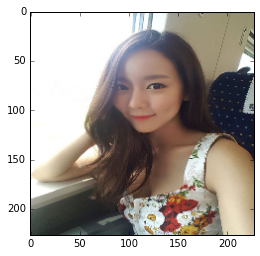

In [62]:
# 아래 있는 ftn 사용하여 이미지 확인한 것임
plt.imshow(deprocess_net_image())


# 아래는 이미지 확인할 때 필요한 ftn

In [61]:
# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image():
    img = caffe.io.load_image('image.jpg')
    preprocessed_image = transformer.preprocess('data', img)
    
    image = preprocessed_image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

# 추가적인 이미지 Test

In [86]:
my_url = "https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13398426_1728421774112464_1071170209_n.jpg?ig_cache_key=MTI3NTA3NzU3MzEzMTU1Mzg1Mg%3D%3D.2"
Results = ootd_preds(net, my_url)
print Results


--2016-06-20 12:13:36--  https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13398426_1728421774112464_1071170209_n.jpg?ig_cache_key=MTI3NTA3NzU3MzEzMTU1Mzg1Mg%3D%3D.2
Resolving scontent.cdninstagram.com (scontent.cdninstagram.com)... 31.13.77.52, 2a03:2880:f00d:14:face:b00c:0:43fe
접속 scontent.cdninstagram.com (scontent.cdninstagram.com)|31.13.77.52|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 67764 (66K) [image/jpeg]
Saving to: ‘image.jpg’

100%[======================================>] 67,764      --.-K/s   in 0.01s   

2016-06-20 12:13:36 (4.54 MB/s) - ‘image.jpg’ saved [67764/67764]

[('Keep', 99.967241287231445), ('Feature', 0.027935564867220819), ('Delete', 0.0048291873099515215)]


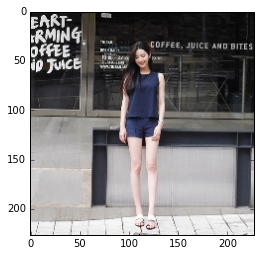

In [64]:
plt.imshow(deprocess_net_image())

In [87]:
my_url = "https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13402445_1546079689035245_1879316882_n.jpg?ig_cache_key=MTI3NjY0NDYwODMzMzAyMTI4OQ%3D%3D.2"
Results = ootd_preds(net, my_url)
print Results

--2016-06-20 12:13:45--  https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13402445_1546079689035245_1879316882_n.jpg?ig_cache_key=MTI3NjY0NDYwODMzMzAyMTI4OQ%3D%3D.2
Resolving scontent.cdninstagram.com (scontent.cdninstagram.com)... 31.13.77.52, 2a03:2880:f00d:14:face:b00c:0:43fe
접속 scontent.cdninstagram.com (scontent.cdninstagram.com)|31.13.77.52|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 54194 (53K) [image/jpeg]
Saving to: ‘image.jpg’

100%[======================================>] 54,194      --.-K/s   in 0.009s  

2016-06-20 12:13:45 (5.70 MB/s) - ‘image.jpg’ saved [54194/54194]

[('Keep', 97.792553901672363), ('Delete', 1.9365230575203896), ('Feature', 0.27092501986771822)]


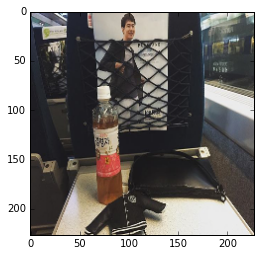

In [66]:
plt.imshow(deprocess_net_image())

In [ ]:
my_url = ""
Results = ootd_preds(net, my_url)
print Results

In [88]:

my_url = "https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13391079_141016972969271_1681295526_n.jpg?ig_cache_key=MTI3NjYzMDQwMDUzMzEzMDM3Nw%3D%3D.2"
Results = ootd_preds(net, my_url)
print Results

--2016-06-20 12:13:54--  https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13391079_141016972969271_1681295526_n.jpg?ig_cache_key=MTI3NjYzMDQwMDUzMzEzMDM3Nw%3D%3D.2
Resolving scontent.cdninstagram.com (scontent.cdninstagram.com)... 31.13.77.52, 2a03:2880:f00d:14:face:b00c:0:43fe
접속 scontent.cdninstagram.com (scontent.cdninstagram.com)|31.13.77.52|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 20065 (20K) [image/jpeg]
Saving to: ‘image.jpg’

100%[======================================>] 20,065      --.-K/s   in 0.003s  

2016-06-20 12:13:54 (6.25 MB/s) - ‘image.jpg’ saved [20065/20065]

[('Delete', 99.969911575317383), ('Keep', 0.029748940141871572), ('Feature', 0.00034637266708159586)]


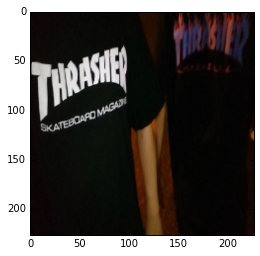

In [69]:
plt.imshow(deprocess_net_image())

In [89]:
my_url = "https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13398641_651826344964472_493791351_n.jpg?ig_cache_key=MTI3NjczOTg4MDI5NDcxNTM4MQ%3D%3D.2"
Results = ootd_preds(net, my_url)

print Results

--2016-06-20 12:13:59--  https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13398641_651826344964472_493791351_n.jpg?ig_cache_key=MTI3NjczOTg4MDI5NDcxNTM4MQ%3D%3D.2
Resolving scontent.cdninstagram.com (scontent.cdninstagram.com)... 31.13.77.52, 2a03:2880:f00d:14:face:b00c:0:43fe
접속 scontent.cdninstagram.com (scontent.cdninstagram.com)|31.13.77.52|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 36093 (35K) [image/jpeg]
Saving to: ‘image.jpg’

100%[======================================>] 36,093      --.-K/s   in 0.04s   

2016-06-20 12:13:59 (828 KB/s) - ‘image.jpg’ saved [36093/36093]

[('Delete', 99.99997615814209), ('Keep', 2.1375630865350104e-05), ('Feature', 5.2200515909817113e-06)]


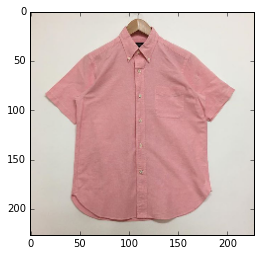

In [71]:
plt.imshow(deprocess_net_image())